In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

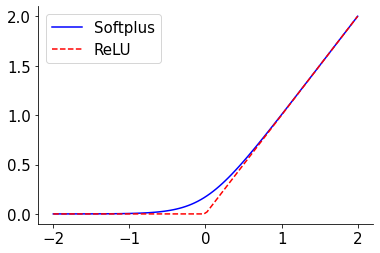

In [2]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
# plt.plot(a,F.elu(a-1)+1,color='red',label='ELU')
plt.plot(a,F.relu(a),'--',color='red',label='ReLU')
plt.legend()
sns.despine()
plt.show()

In [3]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [4]:
class autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.in_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size 
        
        self.in2hidden = nn.Linear(self.in_size, self.hidden_size, bias=False)
        self.hidden2out = nn.Linear(self.hidden_size, self.output_size, bias=False)
    
    def forward(self, input_pattern, act_sharpness=4):
        hidden = self.in2hidden(input_pattern)
        hidden = F.softplus(hidden, beta=act_sharpness)

        output = self.hidden2out(hidden)
        output = F.softplus(output, beta=act_sharpness)

        return output, hidden
    
        
    def train(self, num_epochs, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        hidden_history = torch.zeros(self.hidden_size, num_patterns, num_epochs)
        output_history = torch.zeros(self.output_size, num_patterns, num_epochs)
        loss_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.output_size)[pattern_idx]

                output, hidden = self.forward(input_pattern)
                
                hidden_history[:,pattern_idx,epoch] = hidden.detach()
                output_history[:,pattern_idx,epoch] = output.detach()

                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_history.append(loss.detach())             
                            
        return output_history, hidden_history, torch.tensor(loss_history)
    

100%|██████████| 1000/1000 [00:04<00:00, 207.07it/s]


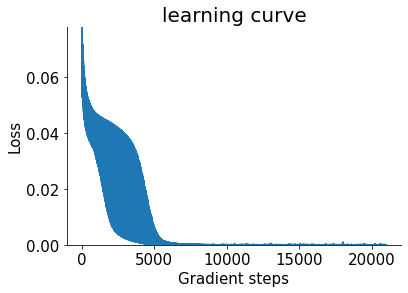

In [5]:
# torch.manual_seed(42)

# Initialize RNN
input_size = 21
hidden_size = 7
output_size = 21

model = autoencoder(input_size, hidden_size, output_size)

# Train network
num_epochs = 1000
lr = 0.001
all_patterns = n_hot_patterns(n=1,length=input_size)
output_history, hidden_history, loss_history = model.train(num_epochs, all_patterns, lr)

plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)

sns.despine()
plt.show()

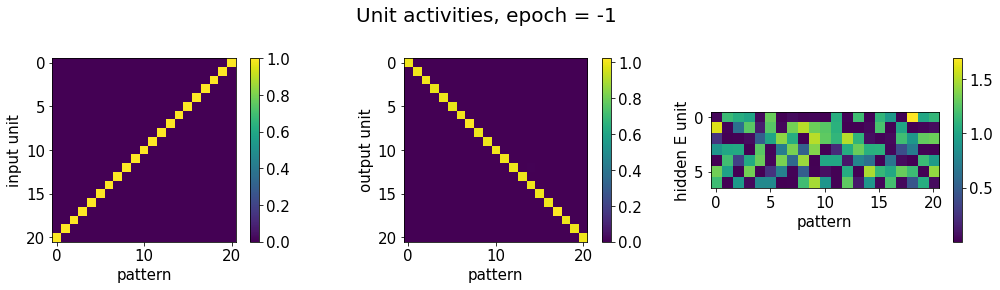

mean population sparsity (hidden) = 0.4843704104423523


In [41]:
epoch = -1

def plot_activity(epoch):
    if epoch > -1:
        epoch = epoch*10
    
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(hidden_history[:,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    plt.suptitle(f"Unit activities, epoch = {epoch}",fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_activity(epoch)


# Sparsity metric from (Vinje & Gallant 2000): https://www.science.org/doi/10.1126/science.287.5456.1273
sparsity = torch.empty(input_size)
for i,pop_activity in enumerate(hidden_history[:,:,-1].T):
    n = pop_activity.shape[0]
    activity_fraction = (torch.sum(pop_activity)/n)**2 / torch.sum(pop_activity**2/n)
    sparsity[i] = (1 - activity_fraction)/(1 - 1/n)
    
print(f"mean population sparsity (hidden) = {torch.mean(sparsity)}")

In [7]:
import ipywidgets as widgets

widgets.interact(plot_activity, epoch=(0,99,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=49, description='epoch', max=99), Output()), _dom_classes=('widget-inter…

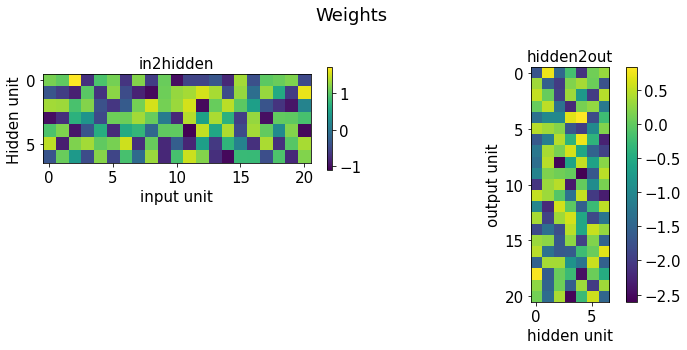

In [8]:
import matplotlib.gridspec as gs

fig = plt.figure(figsize=(10, 5))
axes = gs.GridSpec(nrows=2, ncols=2)
#                    left=0.05,right=0.98,
#                    top = 0.95, bottom = 0.2,
#                    wspace=0.8, hspace=1.2)


# Hidden weights
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(model.in2hidden.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('input unit')
ax.set_ylabel('Hidden unit')
ax.set_title('in2hidden',fontsize=15)

# Output weights
ax = fig.add_subplot(axes[0:2,1])
im = ax.imshow(model.hidden2out.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('hidden unit')
ax.set_ylabel('output unit')
ax.set_title('hidden2out',fontsize=15)

plt.suptitle("Weights")

plt.tight_layout()
plt.show()